In [ ]:
!pip install torch==1.13.1 lifelines==0.27.8 scanpy==1.9.5 pandas==1.5.3 numpy==1.23.5 matplotlib==3.7.2 #scipy==1.10.1

In [1]:
#The scRNA-seq data used in this simulation is derived from the study by Wu et al. (https://doi.org/10.1038/s41588-021-00911-1).
import src.scsurv.workflow as workflow
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

/home/mizukoshi/scSurv/scsurv-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
sc_adata = sc.read_h5ad('tutolial_simulated_sc_reference.h5ad')
bulk_adata = sc.read_h5ad('tutolial_simulated_bulk.h5ad')
bulk_ncells_per_leiden = bulk_adata.uns['n_cells_per_celltype_df'].T
setting_beta = pd.Series(bulk_adata.uns['setting_beta'], index = bulk_ncells_per_leiden.columns)
cell_type_df = sc_adata.obs['celltype_minor']
sc_adata.obs['setting_beta'] = sc_adata.obs['celltype_minor'].map(setting_beta).astype(float)

In [7]:
batch_key = 'orig.ident'
exp_name = 'tutolial_simulation.pt'
epoch = 10000
sc_adata, bulk_adata, model_params_dict, spatial_adata, scsurv_exp = workflow.run_scSurv(sc_adata, bulk_adata, exp_name, epoch, batch_key)

make_sample_one_hot_mat
{'1st_lr': 0.01, '2nd_lr': 0.01, '3rd_lr': 0.0001, 'patience': 10, 'bulk_seed': 0, 'x_batch_size_VAE': 1000, 'x_batch_size_DeepCOLOR': 1000, 'x_batch_size_scSurv': 500, 'n_var': 5000, 'usePoisson_sc': True, 'batch_key': 'orig.ident', 'n_obs_sc': 4305, 'n_obs_bulk': 300, 'method': 'efron', 'use_val_loss_mean:': True, 'bulk_validation_num_or_ratio': 0.2, 'bulk_test_num_or_ratio': 0.2, 'z_dim': 20, 'h_dim': 100, 'num_enc_z_layers': 1, 'num_dec_z_layers': 1, 'num_dec_p_layers': 1, 'num_dec_b_layers': 1, 'x_dim': 5000}
torch.cuda.is_available() True
Start first opt lr= 0.01


/home/mizukoshi/scSurv/scsurv-env/lib/python3.8/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


epoch 0: train loss 9262.179 validation loss 8350.2568359375
epoch 50: train loss 3384.575333333333 validation loss 3563.248046875
epoch 100: train loss 2977.1053333333334 validation loss 3134.629150390625
epoch 150: train loss 2743.3633333333332 validation loss 2916.213134765625
epoch 200: train loss 2620.1615833333335 validation loss 2847.079833984375
epoch 250: train loss 2546.122083333333 validation loss 2732.0703125
epoch 300: train loss 2440.371 validation loss 2676.9697265625
epoch 350: train loss 2390.80125 validation loss 2625.7587890625
epoch 400: train loss 2357.453916666667 validation loss 2582.85205078125
Early Stopping! at 423 epoch, best score=2586.89677734375
Done sc mode, Val Loss: 2589.10546875 Test Loss: 2751.80615234375
bulk mode lr= 0.01
epoch 0: train loss 12285.340333333334 validation loss 28496.72265625
epoch 50: train loss 11018.38 validation loss 25587.130859375
epoch 100: train loss 10335.572 validation loss 24028.83984375
epoch 150: train loss 10010.85366666

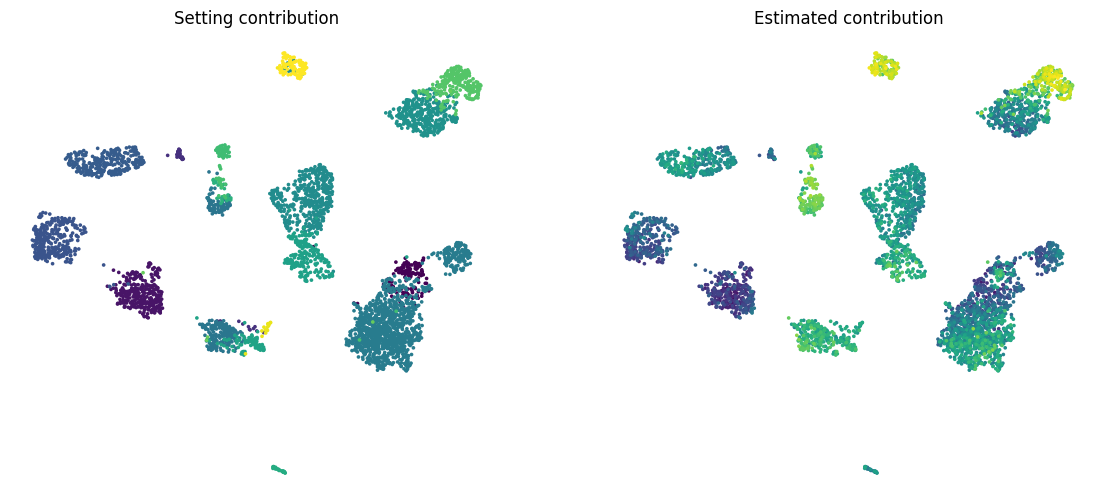

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sc.pl.umap(sc_adata, color='setting_beta', ax=ax1, show=False, colorbar_loc=None, frameon=False, title='Setting contribution')
sc.pl.umap(sc_adata, color='beta_z', ax=ax2, show=False, colorbar_loc=None, frameon=False, title='Estimated contribution')
plt.savefig('umap_setting_and_estimated_beta.png')

In [9]:
estimated_p_sc_level = pd.DataFrame(sc_adata.obsm['map2bulk'].T, index=bulk_adata.obs_names, columns=sc_adata.obs_names)
bulk_ncells = bulk_adata.uns['n_cells_per_celltype_df'].T
estimated_p_cluster = pd.DataFrame(index=bulk_ncells.index, columns=bulk_ncells.columns)
for item in bulk_ncells.columns:
    item_idx = sc_adata[sc_adata.obs['celltype_minor']==item].obs.index
    estimated_p_cluster[item] = estimated_p_sc_level[item_idx].sum(axis=1)

deconv_corr = estimated_p_cluster.corrwith(bulk_ncells, axis=1, method='pearson')
print('scSurv deconvolution correlation', deconv_corr.median())

beta_means = {item: sc_adata[sc_adata.obs['celltype_minor'] == item].obs['beta_z'].mean() 
             for item in bulk_ncells.columns}
beta_corr = pd.Series(beta_means).corr(setting_beta)
print('scSurv contribution correlation', beta_corr)

scSurv deconvolution correlation 0.6213094353306712
scSurv contribution correlation 0.6842311882166421
